## Zillow Housing Forecasting

#### Author: Kyle Dufrane

## Business Understanding:

#### Our stakeholder is a national real estate firm that is looking to invest in the current housing market. They're looking for the top 5 most profitable zip codes from the past 10 years in NY State. 

## Data Understanding

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# from pmdarima import auto_arima

sns.set_style('darkgrid')
pd.set_option('display.max_columns', 999)

import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon_1.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,190326.0,189141.0,189204.0,189184.0,189617.0,190143.0,190050.0,190716.0,191006.0,192332.0,193351.0,194629.0,195822.0,198184.0,199522.0,200279.0,200960.0,201676.0,203826.0,204267.0,205610.0,205330.0,206963.0,209099.0,211915.0,214608.0,218032.0,221994.0,225131.0,228437.0,230544.0,234624.0,238545.0,243892.0,246984.0,249192.0,251478.0,253822.0,256305.0,258086.0,261583.0,265795.0,272467.0,278865.0,286053.0,292290.0,299184.0,306010.0,311352.0,317402.0,323472.0,331723.0,339181.0,346161.0,3

In [55]:
df = df[df['StateName'] == 'NY']

In [56]:
df.columns[:11]

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '1996-01-31', '1996-02-29'],
      dtype='object')

#### This dataset comes from [Zillow Research](https://www.zillow.com/research/data/). The dataset selected is labeled 'ZHVI All Homes (SFR, Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted' filtered by Zip Code.

#### As we can see in the cell above our dataset contains nine columns followed by 305 columns with home values by date. 

#### To start understanding out data, we will identify what each of the first nine columns mean below: 

* RegionID: Based on my research this seems to be Zillow specific.
* SizeRank: Further analysis is needed. 
* RegionName: Zipcode
* RegionType: Denotes region type - I.E. RegionName = Zipcode
* StateName: U.S. State 
* State: U.S. State 
* City: City associated to zipcode
* Metro: Metroplitian Area
* CountyName: name of the county the zipcode resides in

#### At first glance, it looks like these values are at the end of each month starting on January 31st, 1996 and ending on May 31st, 2021. Since our stakeholder is only concerned with the past 15 years we will filter our date columns to January 2006 until present. In Zillows summary they state that these values are representative of a 'typical home value'. They do not elaborate further on their definition. Moving forward we will assume that this is the mean price for all homes within a given zip code. 

#### To get a more indepth look into our data, lets see if we can get a clearer picture on what SizeRank denotes in our dataset. 

In [57]:
df['SizeRank'].value_counts()

31903    5
21142    5
31843    4
32559    4
29472    4
        ..
2750     1
25071    1
700      1
6841     1
5097     1
Name: SizeRank, Length: 1463, dtype: int64

In [58]:
df[df['SizeRank'] == 29685].head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
27746,63115,29685,13435,Zip,NY,NY,Prospect,Utica-Rome,Oneida County,113396.0,111930.0,111365.0,109862.0,109148.0,108962.0,108418.0,107911.0,105338.0,103873.0,102074.0,102033.0,102489.0,105524.0,107995.0,111158.0,111000.0,109111.0,106176.0,103825.0,106520.0,109673.0,113813.0,114607.0,114071.0,110527.0,107173.0,100988.0,99329.0,100185.0,104575.0,108954.0,109640.0,107329.0,103594.0,101654.0,100684.0,98981.0,97425.0,100736.0,103844.0,105718.0,105767.0,104532.0,103340.0,101848.0,101995.0,102613.0,103580.0,105514.0,107023.0,104687.0,99434.0,94463.0,90634.0,89778.0,9

In [59]:
df[df['SizeRank'] == 34430].head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
30787,58001,34430,501,Zip,NY,NY,Holtsville,New York-Newark-Jersey City,Suffolk County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### Above we reviewed the total value counts per unqiue item in the SizeRank column. This didnt lead to much insite as we have a total of 11088 total values in this column. Randomly selecting two variables I filtered the columns to see if any features would catch my eye. After a quick google search on population data I can see that the first five in the first filtered dataframe have a population of +/- 5000 from eachother with a few of them being closer to each other in total count with +/- 100. When I reviewed the second dataframe I found that population did not group these cities due to Northhampton, MA having a population of ~30,000 & Vallecito, CA havin a population ~250. This column could denote some form of county population but since our stakeholder is looking at strictly a profit investment this is unneeded noise at this point. 

#### Two other unrelated items did catch my eye. The first being not all zipcodes are of even legnth. As you can see with Holtsvillem, NY the zipcode is '501' which is not a valie zipcode. With a quick google search, I found that in fact '00501' is the correct zipcode for Holtsville. We will have to keep this in the back of our head later down the road and make sure to make changes as needed for our stakeholder. Secondly, we having missing values in our Metro column and our first date column. We will dive further into this in the next section. 

#### To conclude our data understanding section our dataset from Zillow Research contains typical home values on a monthly occurrence from 1996 to present grouped by zip code. 

#### Next we will begin cleaning our data. 

## Data Cleaning:

#### To start our data cleaning process we will go back to our business understanding. Our stakeholder is only concerned with the past 15 years of price changes therefore we will filter our date columns based on this information. Moving forward our dates will be from 1-31-2011 till 1-31-2021. 

#### Given that we are after 15 years of data at 12 month increments we can assume that this column will be 180 rows from our total row count of 314 which should give us a good starting point to filter our data. 

In [8]:
df.iloc[:, 134:]

,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,871181.0,878796.0,866055.0,836472.0,805700.0,798541.0,814216.0,822587.0,825529.0,819306.0,821865.0,821016.0,815644.0,819915.0,823189.0,845492.0,864690.0,879440.0,879394.0,880878.0,881528.0,887043.0,894954.0,888468.0,877608.0,844712.0,839008.0,841982.0,842909.0,830831.0,802688.0,777861.0,754328.0,739456.0,723880.0,724656.0,722100.0,726020.0,711366.0,689938.0,673123.0,664228.0,662141.0,660674.0,660389.0,660227.0,663001.0,660170.0,661600.0,667320.0,676101.0,683076.0,688060.0,689210.0,694088.0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0,1040011.0,1053436.0,1071606.0,1089141.0
2,924403.0,931007.0,918936.0,891639.0,860760.0,853332.0,869166.0,878761.0,882328.0,876954.0,881746.0,884994.0,880266.0,881900.0,883638.0,909967.0,934441.0,951341.0,957818.0,964904.0,981082.0,983756.0,987241.0,968818.0,963122.0,935603.0,936522.0,933750.0,932680.0,923204.0,888361.0,853891.0,812192.0,798668.0,781915.0,783923.0,773155.0,771683.0,749243.0,726784.0,708

#### We are off by a few rows. We will move our column count six spaces which should put us on in the January time frame. We will then subtract our final dataframe to the beginning of 2021.

In [60]:
df.iloc[:, 189:310]

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1

#### Above we now have our time frame of 1-1-2011 to 1-1-2021. Below we will create a new dataframe with these values along with the first nine columns from the original dataframe.

In [10]:
new_dates = df.iloc[:, 189:310]
original_cols = df.iloc[:, :9]
new_df = pd.concat([original_cols, new_dates], axis=1)

In [61]:
new_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,

##### Now that we have created our dataframe we will see if any NaN values are present.

In [62]:
nan_values = new_df.isna()
nan_columns = nan_values.any()

columns_nan = new_df.columns[nan_columns].tolist()
len(columns_nan)

61

In [64]:
new_df[columns_nan].isna().sum()

Metro         253
2011-01-31      9
2011-02-28      9
2011-03-31      9
2011-04-30      9
             ... 
2015-08-31      1
2015-09-30      1
2015-10-31      1
2015-11-30      1
2015-12-31      1
Length: 61, dtype: int64

#### We have 162 columns that contain NaN's with thousands of NaNs within each column. Moving forward we will have to identify a way to handle these missing values. 

In [65]:
new_df[columns_nan]

,Metro,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31
0,New York-Newark-Jersey City,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0
2,New York-Newark-Jersey City,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0
6,New York-Newark-Jersey City,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1008996.0,1011347.0,1015844.0,1014128.0,1015595.0,1030022.0,1045795.0,1058190.0,1061586.0,1063472.0,1064414.0,1070080.0,1077565.0,1087579.0,1095013.0,1106514.0,1104727.0
10,New York-Newark-Jersey City,377803.0,375183.0,377066.0,377391.0,377254.0,373344.0,370206.0,369661.0,369343.0,369892.0,370438.0,371898.0,372738.0,373351.0,375336.0,380352.0,385138.0,388068.0,389286.0,390842.0,390798.0,391786.0,394058.0,396665.0,400021.0,401329.0,401645.0,399477.0,398494.0,399489.0,401052.0,402826.0,406193.0,409370.0,411698.0,414844.0,416816.0,421080.0,422952.0,427562.0,431846.0,436453.0,442195.0,446993.0,451943.0,455235.0,457501.0,460274.0,466314.0,473314.0,480016.0,485744.0,492329.0,500185.0,505304.0,509865.0,514427.0,520795.0,528899.0,533090.0
11,New York-Newark-Jersey City,118094.0,117806.0,119409.0,118821.0,116366.0,114693.0,114745.0,115648.0,115441.0,114673.0,113048.0,112725.0,112338.0,113782.0,114049.0,115533.0,115606.0,115369.0,113872.0,113506.0,113360.0,113673.0,114838.0,116182.0,116705.0,115006.0,113899.0,113679.0,115461.0,116883.0,118142.0,118476.0,119230.0,120299.0,121201.0,120887.0,120963.0,121807.0,123062.0,123324.0,122794.0,122031.0,121646.0,122335.0,122831.0,123407.0,123197.0,123827.0,125565.0,127083.0,127701.0,128147.0,128990.0,130776.0,132615.0,133121.0,133157.0,132428.0,133063.0,134014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30663,Syracuse,90471.0,90215.0,90058.0,89611.0,89382.0,89691.0,90257.0,90944.0,90717.0,90476.0,90011.0,89800.0,89294.0,88935.0,88553.0,88743.0,89012.0,89529.0,89557.0,89963.0,91152.0,93313.0,95221.0,96522.0,97

In [66]:
new_df[columns_nan].iloc[:, 2:62]

,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31
0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0
2,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0
6,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1008996.0,1011347.0,1015844.0,1014128.0,1015595.0,1030022.0,1045795.0,1058190.0,1061586.0,1063472.0,1064414.0,1070080.0,1077565.0,1087579.0,1095013.0,1106514.0,1104727.0
10,375183.0,377066.0,377391.0,377254.0,373344.0,370206.0,369661.0,369343.0,369892.0,370438.0,371898.0,372738.0,373351.0,375336.0,380352.0,385138.0,388068.0,389286.0,390842.0,390798.0,391786.0,394058.0,396665.0,400021.0,401329.0,401645.0,399477.0,398494.0,399489.0,401052.0,402826.0,406193.0,409370.0,411698.0,414844.0,416816.0,421080.0,422952.0,427562.0,431846.0,436453.0,442195.0,446993.0,451943.0,455235.0,457501.0,460274.0,466314.0,473314.0,480016.0,485744.0,492329.0,500185.0,505304.0,509865.0,514427.0,520795.0,528899.0,533090.0
11,117806.0,119409.0,118821.0,116366.0,114693.0,114745.0,115648.0,115441.0,114673.0,113048.0,112725.0,112338.0,113782.0,114049.0,115533.0,115606.0,115369.0,113872.0,113506.0,113360.0,113673.0,114838.0,116182.0,116705.0,115006.0,113899.0,113679.0,115461.0,116883.0,118142.0,118476.0,119230.0,120299.0,121201.0,120887.0,120963.0,121807.0,123062.0,123324.0,122794.0,122031.0,121646.0,122335.0,122831.0,123407.0,123197.0,123827.0,125565.0,127083.0,127701.0,128147.0,128990.0,130776.0,132615.0,133121.0,133157.0,132428.0,133063.0,134014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30663,90215.0,90058.0,89611.0,89382.0,89691.0,90257.0,90944.0,90717.0,90476.0,90011.0,89800.0,89294.0,88935.0,88553.0,88743.0,89012.0,89529.0,89557.0,89963.0,91152.0,93313.0,95221.0,96522.0,97740.0,98789.0,99180.0,99200.0,98933.0,97676.0,96422.0,94054.0,91974.0,89270.0,87769.0,87308.0,87299.0,87057.0,87818.0,87462.0,87577.0,87243.0,87621.0,88181.0,88742.0,89227.0,88757.0,87782.0,86524.0,85974.0,84880.0,84425.0,83549

#### Looking at the bottom of the above dataframe we can see that some of these values have NaN's from 2006 till 2013. With these rows missing half of our needed data we will drop these values going forward.

In [67]:
new_df[columns_nan].shape[1]

61

#### Below we drop all rows that are missing over 25% of their data.

In [68]:
perc = 25.0
min_count = int(((100-perc)/100)*new_df.shape[1])
mod_df = new_df.dropna(axis=0, 
                        thresh=min_count)
mod_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,

In [17]:
mod_df.iloc[:, 9:]

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1

#### The above dataframe shows that the most data we're missing goes until 12-31-2008. Below we will take a look into all of the columns to verify that we're not still missing a significat amount of values. 

In [69]:
na_values = pd.DataFrame(mod_df.iloc[:,9:].isna().sum())
na_values[na_values[0] >= 1]

,0
2011-01-31,8
2011-02-28,8
2011-03-31,8
2011-04-30,8
2011-05-31,8
2011-06-30,8
2011-07-31,8
2011-08-31,8
2011-09-30,8
2011-10-31,8


#### In the dataframe above we can see all of our rows that contain missing values. We have a sharp decrease in missing values past the 2007 year mark. We will move forward back filling this data which will put these areas at a significant disadvantage to others as they will have the same value for ~3 years. This data is important to keep as these areas, though at a disadvantage, may be seeing booms in the housing market. 

In [19]:
# ffill = mod_df.iloc[:,9:].ffill(axis='columns')
# ffill = ffill.dropna()
# clean_df = pd.concat([mod_df.iloc[:,:9], ffill], axis=1,join='inner')
# clean_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,

In [70]:
clean_df.isna().sum()

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       0
               ..
2020-10-31      0
2020-11-30      0
2020-12-31      0
2021-01-31      0
10_yr_Profit    0
Length: 131, dtype: int64

#### Awesome, we can now see that our first nine columns have zero NaN values and we have eliminated all of our NaN values from all columns post CountyName.

#### Since our stakeholder is only concerned about the top 25 most profitable zip codes. We will create a new column based to show max profit from 2006 to 2021 and sort accordingly. 

In [21]:
clean_df.iloc[:, 9:]

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1

In [71]:
clean_df['10_yr_Profit'] = clean_df['2021-01-31'] - clean_df['2011-01-31']

clean_df = clean_df.sort_values('10_yr_Profit', ascending=False)

clean_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,10_yr_Profit
20675,62309,21453,11962,Zip,NY,NY,Sagaponack,New York-Newark-Jersey City,Suffolk County,3271706.0,3277336.0,3289576.0,3279103.0,3271463.0,3267106.0,3251693.0,3234143.0,3221200.0,3249297.0,3278146.0,3316230.0,3324165.0,3302879.0,3284659.0,3307447.0,3341784.0,3378104.0,3409125.0,3463928.0,3502274.0,3496221.0,3459222.0,3413538.0,3390936.0,3419973.0,3429477.0,3421222.0,3410349.0,3429864.0,3474977.0,3505400.0,3545520.0,3583498.0,3654737.0,3727159.0,3817207.0,3849130.0,3905299.0,3959685.0,4028940.0,4067485.0,4078673.0,4085208.0,4100255.0,4133279.0,4175570.0,4236371.0,4286620.0,4360388.0,4402265.0,4419167.0,4410453.0,4411703.0,4447826.0,4479323.0,4502916.0,4530140.0,4524350.0,4490890.0,4452930.0,4455941.0,4499839.0,4540602.0,4561120.0,4563803.0,4541370.0,4552489.0,4548612.0,4542714.0,4544356.0,4578996.0,4597616.0,4572764.0,4519687.0,4525403.0,4574075.0,4643451.0,4698960.0,4714446.0,4734008.0,4757276.0,4800996.0,4824645.0,4849624.0,4878181.0,4914312.0,4887832.0,4859830.0,4837866.0,4868819.0,4905350.0,4939492.0,4965025.0,4968713.0,4966601.0,4957652.0,4961521.0,4973245.0,5010413.0,5027475.0,5034187.0,5029377.0,5040681.0,5035617.0,5011030.0,4964678.0,4950301.0,4964023.0,5013146.0,5054332.0,5080477.0,5092707.0,5108927.0,5124652.0,5143760.0,5179782.0,5239197.0,5327955.0,5404176.0,5468141.0,2196435.0
14827,62281,15046,11930,Zip,NY,NY,Amagansett,New York-Newark-Jersey City,Suffolk County,1674097.0,1668831.0,1657259.0,1649513.0,1653508.0,1657961.0,1658077.0,1648553.0,1642193.0,1659481.0,1685033.0,1706229.0,1704188.0,1697768.0,1686734.0,1701051.0,1701035.0,1707586.0,1702343.0,1708527.0,1714409.0,1692445.0,1653736.0,1612816.0,1614769.0,1633116.0,1652243.0,1636285.0,1637100.0,1650140.0,1682143.0,1722744.0,1745853.0,1783106.0,1826651.0,1883842.0,1918786.0,1932488.0,1956621.0,2003814.0,2043146.0,2061356.0,2061108.0,2051066.0,2060086.0,2077757.0,2099137.0,2108229.0,2127063.0,2155096.0,2172526.0,2162732.0,2154635.0,2158766.0,2181765.0,2196888.0,2208982.0,2213570.0,2222103.0,2230661.0,2226156.0,2235294.0,2250594.0,2288759.0,2311518.0,2328258.0,2338114.0,2354872.0,2363765.0,2370152.0,2378533.0,2405224.0,2429531.0,2439957.0,2433637.0,2437364.0,2460791.0,2495033.0,2526408.0,2552105.0,2578972.0,2609093.0,2635781.0,2650433.0,2676468.0,2698762.0,2741129.0,2743697.0,2752744.0,2753543.0,2770805.0,2791689.0,2814809.0,2847651.0,2877661.0,2897979.0,2910867.0,2923038.0,2932866.0,2952360.0,2961134.0,2978496.0,2995408.0,3019581.0,3020658.0,2983411.0,2922045.0,2886448.0,2881870.0,2905443.0,2922483.0,2946628.0,2959020.0,2966200.0,2963892.0,2963873.0,2979703.0,3019013.0,3

#### Starting to understand our data. NY has the highest profitability but also highest loss. 

In [23]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.bar(clean_df['State'], clean_df['15_yr_Profit']);

#### To look at our top 25 most profitable zip codes we filter below and plot

In [24]:
top_25_zip = clean_df[:25]
top_25_zip.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,10_yr_Profit
20675,62309,21453,11962,Zip,NY,NY,Sagaponack,New York-Newark-Jersey City,Suffolk County,3271706.0,3277336.0,3289576.0,3279103.0,3271463.0,3267106.0,3251693.0,3234143.0,3221200.0,3249297.0,3278146.0,3316230.0,3324165.0,3302879.0,3284659.0,3307447.0,3341784.0,3378104.0,3409125.0,3463928.0,3502274.0,3496221.0,3459222.0,3413538.0,3390936.0,3419973.0,3429477.0,3421222.0,3410349.0,3429864.0,3474977.0,3505400.0,3545520.0,3583498.0,3654737.0,3727159.0,3817207.0,3849130.0,3905299.0,3959685.0,4028940.0,4067485.0,4078673.0,4085208.0,4100255.0,4133279.0,4175570.0,4236371.0,4286620.0,4360388.0,4402265.0,4419167.0,4410453.0,4411703.0,4447826.0,4479323.0,4502916.0,4530140.0,4524350.0,4490890.0,4452930.0,4455941.0,4499839.0,4540602.0,4561120.0,4563803.0,4541370.0,4552489.0,4548612.0,4542714.0,4544356.0,4578996.0,4597616.0,4572764.0,4519687.0,4525403.0,4574075.0,4643451.0,4698960.0,4714446.0,4734008.0,4757276.0,4800996.0,4824645.0,4849624.0,4878181.0,4914312.0,4887832.0,4859830.0,4837866.0,4868819.0,4905350.0,4939492.0,4965025.0,4968713.0,4966601.0,4957652.0,4961521.0,4973245.0,5010413.0,5027475.0,5034187.0,5029377.0,5040681.0,5035617.0,5011030.0,4964678.0,4950301.0,4964023.0,5013146.0,5054332.0,5080477.0,5092707.0,5108927.0,5124652.0,5143760.0,5179782.0,5239197.0,5327955.0,5404176.0,5468141.0,2196435.0
14827,62281,15046,11930,Zip,NY,NY,Amagansett,New York-Newark-Jersey City,Suffolk County,1674097.0,1668831.0,1657259.0,1649513.0,1653508.0,1657961.0,1658077.0,1648553.0,1642193.0,1659481.0,1685033.0,1706229.0,1704188.0,1697768.0,1686734.0,1701051.0,1701035.0,1707586.0,1702343.0,1708527.0,1714409.0,1692445.0,1653736.0,1612816.0,1614769.0,1633116.0,1652243.0,1636285.0,1637100.0,1650140.0,1682143.0,1722744.0,1745853.0,1783106.0,1826651.0,1883842.0,1918786.0,1932488.0,1956621.0,2003814.0,2043146.0,2061356.0,2061108.0,2051066.0,2060086.0,2077757.0,2099137.0,2108229.0,2127063.0,2155096.0,2172526.0,2162732.0,2154635.0,2158766.0,2181765.0,2196888.0,2208982.0,2213570.0,2222103.0,2230661.0,2226156.0,2235294.0,2250594.0,2288759.0,2311518.0,2328258.0,2338114.0,2354872.0,2363765.0,2370152.0,2378533.0,2405224.0,2429531.0,2439957.0,2433637.0,2437364.0,2460791.0,2495033.0,2526408.0,2552105.0,2578972.0,2609093.0,2635781.0,2650433.0,2676468.0,2698762.0,2741129.0,2743697.0,2752744.0,2753543.0,2770805.0,2791689.0,2814809.0,2847651.0,2877661.0,2897979.0,2910867.0,2923038.0,2932866.0,2952360.0,2961134.0,2978496.0,2995408.0,3019581.0,3020658.0,2983411.0,2922045.0,2886448.0,2881870.0,2905443.0,2922483.0,2946628.0,2959020.0,2966200.0,2963892.0,2963873.0,2979703.0,3019013.0,3

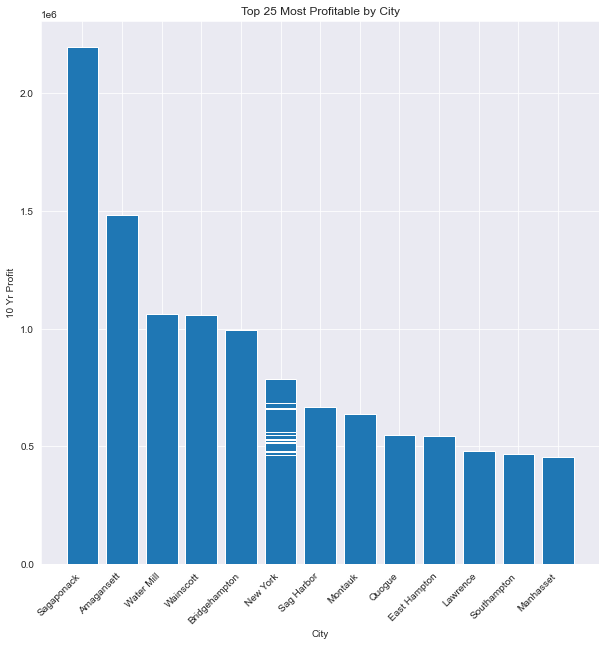

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
plt.bar(top_25_zip['City'], top_25_zip['10_yr_Profit'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 25 Most Profitable by City')
plt.ylabel('10 Yr Profit')
plt.xlabel('City');

#### Next we will move forward dropping all uneeded columns and renaming our column for easier readability. We will move forward using only the RegionName column since our stakeholder is only interested in profit by zipcode.

In [72]:
# time_series_df = top_25_zip.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',\
#                                 'State', 'City', 'Metro', 'CountyName', '15_yr_Profit'], axis=1)
# time_series_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
# time_series_df.head()

time_series_df = clean_df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',\
                                'State', 'City', 'Metro', 'CountyName', '10_yr_Profit'], axis=1)
time_series_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
time_series_df.head()

,Zipcode,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
20675,11962,3271706.0,3277336.0,3289576.0,3279103.0,3271463.0,3267106.0,3251693.0,3234143.0,3221200.0,3249297.0,3278146.0,3316230.0,3324165.0,3302879.0,3284659.0,3307447.0,3341784.0,3378104.0,3409125.0,3463928.0,3502274.0,3496221.0,3459222.0,3413538.0,3390936.0,3419973.0,3429477.0,3421222.0,3410349.0,3429864.0,3474977.0,3505400.0,3545520.0,3583498.0,3654737.0,3727159.0,3817207.0,3849130.0,3905299.0,3959685.0,4028940.0,4067485.0,4078673.0,4085208.0,4100255.0,4133279.0,4175570.0,4236371.0,4286620.0,4360388.0,4402265.0,4419167.0,4410453.0,4411703.0,4447826.0,4479323.0,4502916.0,4530140.0,4524350.0,4490890.0,4452930.0,4455941.0,4499839.0,4540602.0,4561120.0,4563803.0,4541370.0,4552489.0,4548612.0,4542714.0,4544356.0,4578996.0,4597616.0,4572764.0,4519687.0,4525403.0,4574075.0,4643451.0,4698960.0,4714446.0,4734008.0,4757276.0,4800996.0,4824645.0,4849624.0,4878181.0,4914312.0,4887832.0,4859830.0,4837866.0,4868819.0,4905350.0,4939492.0,4965025.0,4968713.0,4966601.0,4957652.0,4961521.0,4973245.0,5010413.0,5027475.0,5034187.0,5029377.0,5040681.0,5035617.0,5011030.0,4964678.0,4950301.0,4964023.0,5013146.0,5054332.0,5080477.0,5092707.0,5108927.0,5124652.0,5143760.0,5179782.0,5239197.0,5327955.0,5404176.0,5468141.0
14827,11930,1674097.0,1668831.0,1657259.0,1649513.0,1653508.0,1657961.0,1658077.0,1648553.0,1642193.0,1659481.0,1685033.0,1706229.0,1704188.0,1697768.0,1686734.0,1701051.0,1701035.0,1707586.0,1702343.0,1708527.0,1714409.0,1692445.0,1653736.0,1612816.0,1614769.0,1633116.0,1652243.0,1636285.0,1637100.0,1650140.0,1682143.0,1722744.0,1745853.0,1783106.0,1826651.0,1883842.0,1918786.0,1932488.0,1956621.0,2003814.0,2043146.0,2061356.0,2061108.0,2051066.0,2060086.0,2077757.0,2099137.0,2108229.0,2127063.0,2155096.0,2172526.0,2162732.0,2154635.0,2158766.0,2181765.0,2196888.0,2208982.0,2213570.0,2222103.0,2230661.0,2226156.0,2235294.0,2250594.0,2288759.0,2311518.0,2328258.0,2338114.0,2354872.0,2363765.0,2370152.0,2378533.0,2405224.0,2429531.0,2439957.0,2433637.0,2437364.0,2460791.0,2495033.0,2526408.0,2552105.0,2578972.0,2609093.0,2635781.0,2650433.0,2676468.0,2698762.0,2741129.0,2743697.0,2752744.0,2753543.0,2770805.0,2791689.0,2814809.0,2847651.0,2877661.0,2897979.0,2910867.0,2923038.0,2932866.0,2952360.0,2961134.0,2978496.0,2995408.0,3019581.0,3020658.0,2983411.0,2922045.0,2886448.0,2881870.0,2905443.0,2922483.0,2946628.0,2959020.0,2966200.0,2963892.0,2963873.0,2979703.0,3019013.0,3080050.0,3129511.0,3157812.0
13825,11976,2509906.0,2495365.0,2479864.0,2466557.0,2457243.0,2456011.0,2447136.0,2436672.0,2424095.0,2428189.0,2440204.0,2444283.0,2447060.0,2416318.0,2393470.0,2383057.0,2394094.0,2407648.0,2414888.0,2424869.0,2430

In [73]:
time_series_df['Zipcode'] = time_series_df['Zipcode'].astype(str)

#### Now that we have our dataframe to where we want it we will begin moving our date columns to the index. We will begin with a transpose and then setting our zipcodes as our columns.

In [74]:
time_series_df = time_series_df.T
time_series_df.head()

,20675,14827,13825,18984,16295,2122,10585,7955,65,513,10119,2587,16248,11738,3601,26967,2124,1181,1785,11531,215,2003,6658,106,7535,3074,374,1375,416,11406,75,2108,2,128,12657,18172,391,18,1528,4098,413,0,31,16720,7401,6137,9515,25440,122,315,3475,602,1468,6378,325,20488,7256,10687,1945,13698,817,424,2468,5342,8596,2789,9265,308,25861,18655,12062,10106,41,2828,4162,6444,5086,375,2142,9577,7559,13617,10,165,14261,16856,1263,110,3541,21269,498,2041,9610,5490,438,7422,3772,11864,4676,5705,10383,1176,24002,7227,5365,20953,8117,20499,6825,20243,6780,9180,6204,507,8466,22076,90,21264,6470,9783,9208,9349,13411,16323,86,2731,19634,5977,12223,4959,1162,6546,5083,18858,118,11898,5539,788,6606,7980,246,11976,3494,21669,251,121,10964,7817,11736,12504,6511,7491,3141,59,8040,10547,2386,2209,4343,13642,9563,7027,6567,63,4411,203,22979,26653,729,10362,3648,578,942,58,84,2474,26787,14161,2296,124,6212,16747,9165,6154,25,493,7637,5035,23947,6096,109,54,6574,1577,4777,11397,1066,27810,698,23181,20,9631,3301,11267,3461,2880,7603,11379,1302,855,2442,277,3095,6384,8059,3524,4905,11873,4922,2794,29,182,2577,13960,5625,2361,15205,9017,1073,1787,4682,954,4423,9806,3911,26773,3717,724,4552,9382,6835,8334,5684,1645,6276,4085,4080,789,1702,10824,27271,1563,10676,11555,1149,650,52,9666,7920,6403,29910,12360,4779,3199,27700,5352,8261,3878,4807,9953,12494,10979,25114,8027,28158,9612,985,10310,6602,5007,22313,8317,9770,5193,19,7888,1739,13189,1122,2494,12664,8469,17343,6053,5162,9070,1891,9380,12132,6389,14131,5559,6285,1414,8820,5529,7815,267,14,9984,18292,12708,3049,9454,10492,8799,15680,3976,709,10223,10863,5050,22258,920,6084,26684,6423,5089,23109,9434,12966,5719,30298,17622,3483,7957,4172,25917,8866,7614,14328,15721,10921,23401,10970,5043,3000,16079,11250,5498,14105,10834,6820,2596,8525,14515,15209,6449,6169,20505,995,27487,28716,9784,29890,9488,9233,4548,25572,25380,14468,49,6526,8722,18677,371,24398,6864,17493,5998,3473,20677,17836,23199,16221,181,19664,8638,17337,7254,61,27662,18154,28491,10129,13408,26819,14015,15350,8581,23633,10034,23069,2635,10037,3204,21816,18481,26723,6854,28705,6,24536,29959,17797,12073,26502,819,24670,17320,24478,19827,17710,11351,5811,4990,26423,11316,26198,6431,26545,7600,5856,8828,3315,27503,21033,25805,4473,15581,7166,16765,7951,13781,6146,18093,10596,29367,29923,4533,12123,22872,21914,7531,232,14003,5141,13490,28181,11426,13563,29013,20805,3149,8109,9606,27585,14123,9800,12951,17490,511,5094,10501,4448,30259,23471,9775,20785,24406,16141,24141,8777,11430,24692,16003,2968,12021,17299,11,23134,5494,8597,26268,12338,21094,27544,17044,29586,...,17400,27759,21962,19443,21883,30110,28443,18851,19159,30011,6563,17979,28533,551,17661,28331,26797,7517,16167,19068,21608,26920,23558,23956,29131,18951,17339,17675,11062,15452,18469,15220,16718,29536,21917,14076,24595,15257,30130,16174,25880,18588,16595,20160,16393,23464,21761,15565,28657,18182,18774,18323,21026,24510,9031,7999,14936,21074,23966,13457,18838,22788,27087,20399,26224,20556,12345,13461,20267,26568,12932,24464,5377,22919,19245,17825,10259,22699,18203,26071,11824,6826,24892,12559,5660,27705,16469,6675,28594,11825,8803,29085,20394,12693,17308,19970,30402,29867,25801,7170,20635,24117,22288,13422,27398,28845,20250,18080,11770,23607,11938,29900,20476,28247,25650,19893,22389,13872,28040,5692,15965,20226,25288,10779,19407,11013,21311,18584,26892,22641,17159,20618,18694,17371,5618,25265,12241,19761,24817,13063,17086,20545,23470,9809,16172,20944,27536,5608,22595,22820,15064,4855,3951,15393,17538,22918,16364,21128,17562,24649,11820,28999,24374,29337,8516,18653,6051,15603,12772,25734,30236,27412,12878,17913,23590,3411,19626,24007,3251,15448,1458,9373,11299,12746,18041,19639,18665,14624,9269,14319,14365,19786,20437,21116,12633,19291,18263,28489,18241,27533,8429,10374,17379,13510,14215,29752,17276,27155,24314,19623,27358,23559,9700,27630,24912,26159,21465,14761,28419,12937,19216,9618,13279,7859,23091,9337,26505,29521,13020,25226,11420,21597,1567,5860,12305,25113,26588,28388,27746,22716,

#### In the above dataframe we can see that the first row is all of our zip codes. Below we will grab that first row and set it as our column header.

In [75]:
#Selecting first row
time_series_df_header = time_series_df.iloc[0]
#Selecting the rest of the dataframe
time_series_df = time_series_df.iloc[1:]
#Setting time_series_df_header as our columns
time_series_df.columns = time_series_df_header
time_series_df

Zipcode         11962      11930      11976      11975      11932      10013  \
2011-01-31  3271706.0  1674097.0  2509906.0  1467913.0  2029820.0  2054269.0   
2011-02-28  3277336.0  1668831.0  2495365.0  1485407.0  2024772.0  2093393.0   
2011-03-31  3289576.0  1657259.0  2479864.0  1500505.0  2024922.0  2126475.0   
2011-04-30  3279103.0  1649513.0  2466557.0  1515846.0  2016559.0  2153380.0   
2011-05-31  3271463.0  1653508.0  2457243.0  1507044.0  2010303.0  2177813.0   
...               ...        ...        ...        ...        ...        ...   
2020-09-30  5179782.0  2979703.0  3340558.0  2333587.0  2824601.0  2888877.0   
2020-10-31  5239197.0  3019013.0  3387967.0  2392666.0  2866778.0  2885744.0   
2020-11-30  5327955.0  3080050.0  3450562.0  2447402.0  2916091.0  2874884.0   
2020-12-31  5404176.0  3129511.0  3516229.0  2496268.0  2971654.0  2865523.0   
2021-01-31  5468141.0  3157812.0  3571252.0  2524212.0  3025601.0  2840343.0   

Zipcode         10007      11963      11221      11216      11954      10012  \
2011-01-31  1961826.0  1204207.0   457414.0   429541.0  1026230.0  1356284.0   
2011-02-28  1993863.0  1204203.0   455972.0   426412.0  1036208.0  1385079.0   
2011-03-31  2026495.0  1203908.0   461298.0   430925.0  1044281.0  1405637.0   
2011-04-30  2047938.0  1197999.0   466137.0   435097.0  1045268.0  1429343.0   
2011-05-31  2068259.0  1194647.0   469439.0   441339.0  1046907.0  1447172.0   
...               ...        ...        ...        ...        ...        ...   
2020-09-30  2677998.0  1754190.0  1117697.0  1090455.0  1533710.0  1960901.0   
2020-10-31  2676241.0  1779443.0  1114687.0  1090067.0  1562519.0  1943805.0   
2020-11-30  2665980.0  1809540.0  1114013.0  1090771.0  1609998.0  1922244.0   
2020-12-31  2663859.0  1842999.0  1119321.0  1090212.0  1638272.0  1913909.0   
2021-01-31  2645354.0  1872106.0  1121997.0  1087583.0  1665682.0  1915644.0   

Zipcode         11959      10282      11937      11243      11231      11222  \
2011-01-31  1655005.0  1741656.0   965965.0   846169.0   825186.0   521139.0   
2011-02-28  1642998.0  1765138.0   972829.0   847531.0   817974.0   517625.0   
2011-03-31  1636349.0  1778264.0   977979.0   860192.0   831796.0   525617.0   
2011-04-30  1630418.0  1792847.0   981295.0   868224.0   845398.0   532324.0   
2011-05-31  1635246.0  1803794.0   985057.0   875628.0   859008.0   540189.0   
...               ...        ...        ...        ...        ...        ...   
2020-09-30  2064215.0  2302082.0  1415222.0  1381109.0  1363615.0  1035139.0   
2020-10-31  2097443.0  2300280.0  1434524.0  1385772.0  1362400.0  1036782.0   
2020-11-30  2131472.0  2298833.0  1456098.0  1389160.0  1362269.0  1039587.0   
2020-12-31  2170818.0  2300460.0  1476997.0  1388431.0  1360326.0  1041482.0   
2021-01-31  2203963.0  2288585.0  1511525.0  1378196.0  1352278.0  1039988.0   

Zipcode         11249      11559     11233     11237      11968      11211  \
2011-01-31   725002.0  1046033.0  389497.0  382634.0  1117953.0   547519.0   
2011-02-28   722319.0  1036964.0  388868.0  380780.0  1118316.0   544677.0   
2011-03-31   718335.0  1031039.0  390861.0  383371.0  1117955.0   553726.0   
2011-04-30   714650.0  1030820.0  390356.0  383786.0  1115494.0   559377.0   
2011-05-31   710752.0  1032612.0  388753.0  380746.0  1115729.0   564388.0   
...               ...        ...       ...       ...        ...        ...   
2020-09-30  1235377.0  1475061.0  842250.0  859783.0  1484281.0   999690.0   
2020-10-31  1234807.0  1491536.0  847082.0  857572.0  1507534.0  1002079.0   
2020-11-30  1238580.0  1505349.0  853860.0  856939.0  1533566.0  1005339.0   
2020-12-31  1236602.0  1518397.0  860108.0  855427.0  1560227.0  1008094.0   
2021-01-31  1238024.0  1526813.0  868101.0  856845.0  1584731.0  1009234.0   

Zipcode         11030     11105     11225      11217     11213      11978  \
2011-01-31  1209193.0  505180.0  335925.0   671232.0  458251.0  1007704.0   
2011-02-28  1206907.0  507

#### Next we will set our dates to the datetime format needed for time series.

In [76]:
time_series_df.index = pd.to_datetime(time_series_df.index)
time_series_df = time_series_df.astype(int)
time_series_df.reset_index()
time_series_df

Zipcode       11962    11930    11976    11975    11932    10013    10007  \
2011-01-31  3271706  1674097  2509906  1467913  2029820  2054269  1961826   
2011-02-28  3277336  1668831  2495365  1485407  2024772  2093393  1993863   
2011-03-31  3289576  1657259  2479864  1500505  2024922  2126475  2026495   
2011-04-30  3279103  1649513  2466557  1515846  2016559  2153380  2047938   
2011-05-31  3271463  1653508  2457243  1507044  2010303  2177813  2068259   
...             ...      ...      ...      ...      ...      ...      ...   
2020-09-30  5179782  2979703  3340558  2333587  2824601  2888877  2677998   
2020-10-31  5239197  3019013  3387967  2392666  2866778  2885744  2676241   
2020-11-30  5327955  3080050  3450562  2447402  2916091  2874884  2665980   
2020-12-31  5404176  3129511  3516229  2496268  2971654  2865523  2663859   
2021-01-31  5468141  3157812  3571252  2524212  3025601  2840343  2645354   

Zipcode       11963    11221    11216    11954    10012    11959    10282  \
2011-01-31  1204207   457414   429541  1026230  1356284  1655005  1741656   
2011-02-28  1204203   455972   426412  1036208  1385079  1642998  1765138   
2011-03-31  1203908   461298   430925  1044281  1405637  1636349  1778264   
2011-04-30  1197999   466137   435097  1045268  1429343  1630418  1792847   
2011-05-31  1194647   469439   441339  1046907  1447172  1635246  1803794   
...             ...      ...      ...      ...      ...      ...      ...   
2020-09-30  1754190  1117697  1090455  1533710  1960901  2064215  2302082   
2020-10-31  1779443  1114687  1090067  1562519  1943805  2097443  2300280   
2020-11-30  1809540  1114013  1090771  1609998  1922244  2131472  2298833   
2020-12-31  1842999  1119321  1090212  1638272  1913909  2170818  2300460   
2021-01-31  1872106  1121997  1087583  1665682  1915644  2203963  2288585   

Zipcode       11937    11243    11231    11222    11249    11559   11233  \
2011-01-31   965965   846169   825186   521139   725002  1046033  389497   
2011-02-28   972829   847531   817974   517625   722319  1036964  388868   
2011-03-31   977979   860192   831796   525617   718335  1031039  390861   
2011-04-30   981295   868224   845398   532324   714650  1030820  390356   
2011-05-31   985057   875628   859008   540189   710752  1032612  388753   
...             ...      ...      ...      ...      ...      ...     ...   
2020-09-30  1415222  1381109  1363615  1035139  1235377  1475061  842250   
2020-10-31  1434524  1385772  1362400  1036782  1234807  1491536  847082   
2020-11-30  1456098  1389160  1362269  1039587  1238580  1505349  853860   
2020-12-31  1476997  1388431  1360326  1041482  1236602  1518397  860108   
2021-01-31  1511525  1378196  1352278  1039988  1238024  1526813  868101   

Zipcode      11237    11968    11211    11030   11105   11225    11217  \
2011-01-31  382634  1117953   547519  1209193  505180  335925   671232   
2011-02-28  380780  1118316   544677  1206907  507411  334298   667052   
2011-03-31  383371  1117955   553726  1208125  512706  341026   682986   
2011-04-30  383786  1115494   559377  1209860  515583  348517   695874   
2011-05-31  380746  1115729   564388  1214213  517758  354328   708592   
...            ...      ...      ...      ...     ...     ...      ...   
2020-09-30  859783  1484281   999690  1627369  958106  763032  1085605   
2020-10-31  857572  1507534  1002079  1637387  962207  762025  1084080   
2020-11-30  856939  1533566  1005339  1648612  964076  763034  1087449   
2020-12-31  855427  1560227  1008094  1657072  963891  766497  1090218   
2021-01-31  856845  1584731  1009234  1665802  958879  766851  1086424   

Zipcode      11213    11978    10024   11103    10023    11215    11024  \
2011-01-31  458251  1007704   897956  389365   729474   700242  1529471   
2011-02-28  455056  1007614   909526  389465   741641   695429  1527397   
2011-03-31  456852  1007777   919560  392497   748578   708116  1527578   
2011-04-30  457860  1006591   926801  392884   7

### Time Series Split

#### To start our modeling process, we begin separating our data set into 80/20 splits for our training and testing sets

In [77]:
test = pd.DataFrame()
train = pd.DataFrame()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(time_series_df):
    train, test = time_series_df.iloc[train_index.min():train_index.max(), :],\
                      time_series_df.iloc[test_index.min():test_index.max(), :]

In [78]:
train

Zipcode       11962    11930    11976    11975    11932    10013    10007  \
2011-01-31  3271706  1674097  2509906  1467913  2029820  2054269  1961826   
2011-02-28  3277336  1668831  2495365  1485407  2024772  2093393  1993863   
2011-03-31  3289576  1657259  2479864  1500505  2024922  2126475  2026495   
2011-04-30  3279103  1649513  2466557  1515846  2016559  2153380  2047938   
2011-05-31  3271463  1653508  2457243  1507044  2010303  2177813  2068259   
...             ...      ...      ...      ...      ...      ...      ...   
2018-12-31  4966601  2897979  3287778  2349568  2736736  3058692  2883547   
2019-01-31  4957652  2910867  3283712  2348700  2732382  3054320  2873945   
2019-02-28  4961521  2923038  3274162  2357074  2728249  3044332  2863858   
2019-03-31  4973245  2932866  3282067  2359497  2733018  3027715  2852505   
2019-04-30  5010413  2952360  3292698  2381985  2754345  3006497  2838579   

Zipcode       11963    11221    11216    11954    10012    11959    10282  \
2011-01-31  1204207   457414   429541  1026230  1356284  1655005  1741656   
2011-02-28  1204203   455972   426412  1036208  1385079  1642998  1765138   
2011-03-31  1203908   461298   430925  1044281  1405637  1636349  1778264   
2011-04-30  1197999   466137   435097  1045268  1429343  1630418  1792847   
2011-05-31  1194647   469439   441339  1046907  1447172  1635246  1803794   
...             ...      ...      ...      ...      ...      ...      ...   
2018-12-31  1691238  1125673  1119615  1477833  2033978  2012164  2559117   
2019-01-31  1692736  1119550  1112972  1493059  2049867  2002040  2552739   
2019-02-28  1694600  1113893  1103824  1508288  2097212  1991601  2538150   
2019-03-31  1702401  1113278  1100580  1512249  2120599  1990923  2513485   
2019-04-30  1712379  1113161  1099051  1518581  2099536  1990252  2487505   

Zipcode       11937    11243    11231    11222    11249    11559   11233  \
2011-01-31   965965   846169   825186   521139   725002  1046033  389497   
2011-02-28   972829   847531   817974   517625   722319  1036964  388868   
2011-03-31   977979   860192   831796   525617   718335  1031039  390861   
2011-04-30   981295   868224   845398   532324   714650  1030820  390356   
2011-05-31   985057   875628   859008   540189   710752  1032612  388753   
...             ...      ...      ...      ...      ...      ...     ...   
2018-12-31  1421261  1400614  1372113  1031372  1235924  1391140  811158   
2019-01-31  1419408  1404677  1375013  1035182  1244425  1394127  811933   
2019-02-28  1410868  1401877  1373078  1033766  1245125  1403576  810626   
2019-03-31  1410259  1400757  1374735  1034618  1249595  1409559  813082   
2019-04-30  1411080  1395209  1374503  1032235  1247061  1411087  815791   

Zipcode      11237    11968   11211    11030   11105   11225    11217   11213  \
2011-01-31  382634  1117953  547519  1209193  505180  335925   671232  458251   
2011-02-28  380780  1118316  544677  1206907  507411  334298   667052  455056   
2011-03-31  383371  1117955  553726  1208125  512706  341026   682986  456852   
2011-04-30  383786  1115494  559377  1209860  515583  348517   695874  457860   
2011-05-31  380746  1115729  564388  1214213  517758  354328   708592  459051   
...            ...      ...     ...      ...     ...     ...      ...     ...   
2018-12-31  842571  1452896  971371  1640125  909519  757127  1142267  866178   
2019-01-31  840891  1452532  976064  1639642  909773  763804  1150614  862882   
2019-02-28  838486  1452836  976293  1642911  914465  770869  1151734  859172   
2019-03-31  840164  1455199  979736  1642541  920391  777415  1155965  860625   
2019-04-30  841621  1459703  980338  1641850  924622  781125  1154518  863970   

Zipcode       11978    10024   11103    10023    11215    11024    11965  \
2011-01-31  1007704   897956  389365   729474   700242  1529471  1082545   
2011-02-28  1007614   909526  389465   741641   695429  1527397  1082609   
2011-03-31  1007777   919560  392497

#### First Simple Model

#### Below we will take the baseline RMSE value from each of our zip codes. We will use these values for comparison while building our models. 

In [79]:
rmse_baselines = {}

for col in time_series_df.columns:

    yhat = train[col].rolling(window=10).mean().dropna()

    ytrue = train[col][9:].dropna()

    rmse_baselines[col] = np.sqrt(mean_squared_error(ytrue, yhat))


In [34]:
# rmse_baselines

#### Now that we have our baselines we will begin to transform our data. The first step will be to verify that our data is normally distributed. We will look at the dataset to get a visual representation.

#### As we can see our data is skewed and will need to be transformed. We will start with a log transformation.

#### Above we can see that our data is normally distributed once we have performed the log transformation. We will move forward applying this transformation to both our training and testing sets and visually verify both are normally distributed.

In [37]:
# train = np.log(train)
# test = np.log(test)

#### Below we will look at our rolling mean and std to verify stationarity through visualization and a dicky fuller test.

#### As we can see our data is significantly more stationary visually than previous tests although our p-values are not showing us stationarity as they are above 0.05. We will have to apply different tests to achieve stationarity. 

In [38]:
train.head()

Zipcode,11962,11930,11976,11975,11932,10013,10007,11963,11221,11216,11954,10012,11959,10282,11937,11243,11231,11222,11249,11559,11233,11237,11968,11211,11030,11105,11225,11217,11213,11978,10024,11103,10023,11215,11024,11965,11101,11201,11205,11228,11204,10025,10128,11568,10580,11021,11366,11956,11238,11223,11358,10014,10065,11369,10021,11957,11370,11023,10026,11020,11210,11219,10075,11378,10044,11357,11576,11218,12844,11960,11516,10069,11206,10454,11379,11239,11361,11208,11365,11577,11356,11935,11226,11385,11977,11964,11432,10453,11104,11958,11203,11102,11598,11419,10032,10018,11050,11363,11420,11418,11971,11106,11765,10538,11421,11770,11426,11947,11427,11948,11417,11416,11423,11220,11428,11547,11229,10518,11694,11545,11436,10803,11579,11509,11207,11040,12409,11001,11507,11530,10461,11232,11412,11939,11234,11944,11433,10472,11946,11362,10027,11952,10030,11548,11236,11355,11565,11429,11942,11096,11422,14222,11364,11212,11411,10706,10583,11367,11413,14202,11753,11581,11552,11209,11003,10028,10597,11970,11374,11596,11580,11354,11691,11230,11214,11590,12574,11514,10304,10314,11563,11724,10528,11501,10009,11368,10005,10952,11430,11791,11377,10003,11010,10001,11414,10533,10469,12820,10466,12457,11375,11575,11554,12498,11717,10305,11553,11557,10475,11434,10301,11372,10465,10310,10470,11801,10309,10006,11803,11756,10011,11373,11520,11804,11360,10455,11732,10280,10312,11550,11570,10306,11793,11518,11710,12495,11566,10036,11572,11798,11783,14201,10308,11561,11714,11735,11510,10473,11435,11797,12841,10459,11740,11558,11758,11746,10019,10307,11703,12508,12507,11721,11722,11704,12448,11729,10302,10017,11731,11713,10607,14032,10519,11702,12541,10522,10010,13152,11762,11542,11972,11949,14209,11763,11235,11788,10977,10502,11706,11757,10004,11738,11931,14051,10471,11742,11743,11755,11560,11784,10532,11720,11747,11772,11004,10591,11726,10701,10016,11771,12461,10595,11779,10570,10553,11950,11796,11727,10460,10709,11792,11741,12824,11224,11967,12874,10303,11725,12494,12572,11786,11415,12943,10537,11787,11780,11901,12410,11767,11782,11715,11719,14068,12942,11933,14216,10550,11718,11705,11701,12526,11752,14052,10705,10520,10594,12484,10543,11795,10546,12866,12725,12512,14031,12872,11766,11764,10598,12444,12433,10524,10456,10703,11693,10505,14221,12480,14214,12440,11776,10704,12464,13420,13360,11941,10468,14478,11730,14170,11754,10463,12465,12521,12441,11769,14604,12416,12404,12529,11751,12412,14059,10517,14086,11716,14127,12136,12516,12475,10603,13472,10002,12419,12858,14033,10590,10587,10033,10527,11749,10981,12481,14139,11789,14072,14607,12517,11934,10931,10605,13436,11961,14213,11790,14534,12976,12502,12017,10037,12075,12561,12106,10606,12037,12534,12740,14472,12115,12544,10710,10994,14026,14102,11733,10457,14080,14220,11980,12977,12184,10464,14785,12997,10573,11953,14004,12429,11955,10514,11940,12583,10031,14228,10510,10956,12864,13337,12571,12029,13331,14025,12863,11778,14085,13740,14543,14226,11709,12581,10467,10535,14618,10804,12417,13326,12513,12471,10588,12915,...,13092,14881,13328,12155,13780,13738,13102,13616,14034,12862,12801,14516,13483,12180,12926,12071,13863,10549,14203,13034,13750,12742,12914,13756,12784,12747,13042,13495,14470,14081,14718,12775,12779,13784,13368,13605,14824,14821,14557,13471,13406,13425,13746,13433,13143,12434,12092,14812,14135,14427,13775,12748,14802,13469,14411,14513,13131,14803,13777,12122,13052,13071,13162,12592,12884,14861,13309,13655,12067,12955,13166,12418,10901,12786,13083,13673,12204,14747,14066,14877,12158,12206,12923,14590,12189,12041,13612,13203,13457,12822,12953,12031,14894,13733,13656,14709,13415,13675,13841,14611,12070,13844,13464,13830,10932,13806,12815,12723,14569,13454,13073,13065,13302,12854,13155,14550,12934,14871,12720,10552,13730,13338,13687,13035,12729,13856,12929,13156,14714,13147,13606,13054,12783,14735,14830,13832,12563,12957,14846,12143,13120,13801,12035,14437,12138,14804,13103,14845,12175,12960,14738,12208,12306,13033,12197,13744,14517,14898,12788,12930,12186,14542,12843,12069,13207,1314

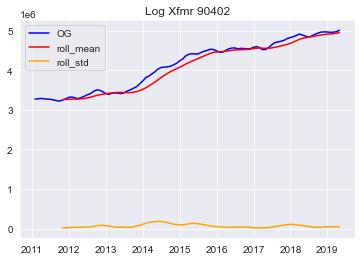

In [80]:
roll_mean = train['11962'].rolling(window=10).mean()
roll_std = train['11962'].rolling(window=10).std()
plt.plot(train['11962'], color='blue', label='OG')
plt.plot(roll_mean, color='red', label='roll_mean')
plt.plot(roll_std, color='orange', label='roll_std')
plt.title(f'Log Xfmr 90402')
plt.legend();

In [40]:
dftest_log = adfuller(train['11962'])
dfoutput = pd.Series(dftest_log[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput

Test Statistic                 -0.853584
p-value                         0.802874
#Lags Used                      5.000000
Number of Observations Used    94.000000
dtype: float64

#### Square root - as we can see below applying the square root performs worse than the log transformation. 

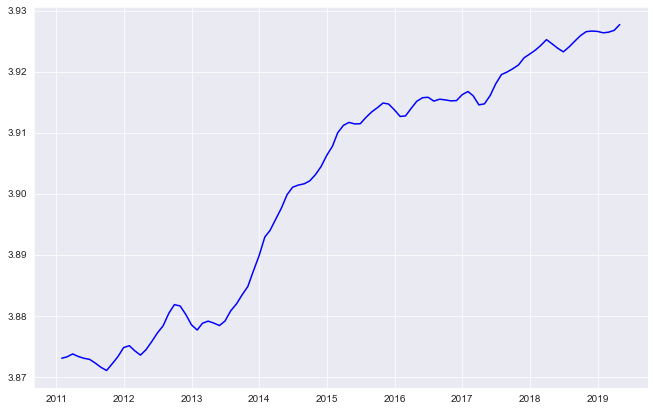

In [41]:
data = pd.Series(np.sqrt(train['11962']))
fig = plt.figure(figsize=(11,7))
plt.plot(data, color='blue')
plt.show()

In [42]:
dftest_sqrt = adfuller(data)
dfoutput = pd.Series(dftest_sqrt[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput

Test Statistic                 -0.862524
p-value                         0.800063
#Lags Used                      5.000000
Number of Observations Used    94.000000
dtype: float64

#### Subtracting the rolling mean - as we see below this is our best performing transformation with a p-value of 0.052949!

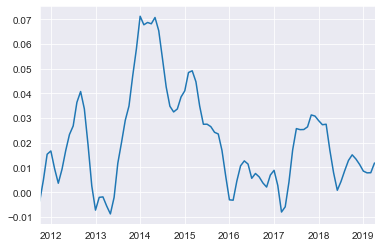

In [43]:
roll_mean = train['11962'].rolling(window=10).mean().dropna()
train_90402_minus_roll_mean = train['11962'] - roll_mean
train_90402_minus_roll_mean.dropna(inplace=True)
train_90402_minus_roll_mean.plot();

In [44]:
dftest_roll_mean = adfuller(train_90402_minus_roll_mean)
dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput

Test Statistic                 -3.329268
p-value                         0.013620
#Lags Used                      4.000000
Number of Observations Used    86.000000
dtype: float64

In [45]:
for i in range(1,20):    
    
    roll_mean = train['11962'].rolling(window=i).mean().dropna()
    train_90402_minus_roll_mean = train['11962'] - roll_mean
    dftest_roll_mean = adfuller(train_90402_minus_roll_mean.dropna())
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    print(f'---------Total Windows: {i}-----------')
    print(dfoutput)

---------Total Windows: 1-----------
Test Statistic                  NaN
p-value                         NaN
#Lags Used                      0.0
Number of Observations Used    99.0
dtype: float64
---------Total Windows: 2-----------
Test Statistic                 -1.843714
p-value                         0.358985
#Lags Used                     12.000000
Number of Observations Used    86.000000
dtype: float64
---------Total Windows: 3-----------
Test Statistic                 -1.68310
p-value                         0.43984
#Lags Used                     12.00000
Number of Observations Used    85.00000
dtype: float64
---------Total Windows: 4-----------
Test Statistic                 -1.492177
p-value                         0.537378
#Lags Used                     12.000000
Number of Observations Used    84.000000
dtype: float64
---------Total Windows: 5-----------
Test Statistic                 -1.453713
p-value                         0.556272
#Lags Used                     12.000000


#### Above we can see that 8 Windows gives us a p-value of 0.008890 which is by far our best result. We will try one more test below.

#### Finally we will try differencing.

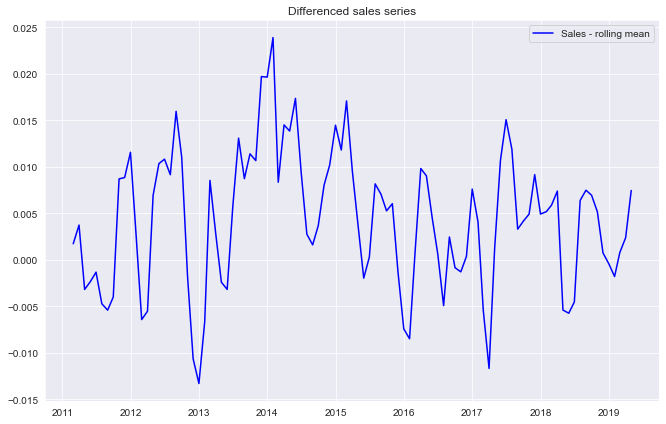

In [46]:
data_diff = train['11962'].diff(periods=1).dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [47]:
data_diff = train['11962'].diff(periods=1).dropna()

dftest_diff = adfuller(data_diff)
dfoutput = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput

Test Statistic                 -1.843714
p-value                         0.358985
#Lags Used                     12.000000
Number of Observations Used    86.000000
dtype: float64

#### Our Dicky Fuller test gives us an output of 0.4. Lets run a loop to see if we are able to improve the score.

In [48]:
for i in range(1,20):    
    
    data_diff = train['11962'].diff(periods=i).dropna()

    dftest_diff = adfuller(data_diff)
    dfoutput = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print(f'---------Total Periods: {i}-----------')
    print(dfoutput)

---------Total Periods: 1-----------
Test Statistic                 -1.843714
p-value                         0.358985
#Lags Used                     12.000000
Number of Observations Used    86.000000
dtype: float64
---------Total Periods: 2-----------
Test Statistic                 -2.011179
p-value                         0.281693
#Lags Used                     11.000000
Number of Observations Used    86.000000
dtype: float64
---------Total Periods: 3-----------
Test Statistic                 -3.262888
p-value                         0.016621
#Lags Used                      7.000000
Number of Observations Used    89.000000
dtype: float64
---------Total Periods: 4-----------
Test Statistic                 -1.994491
p-value                         0.288994
#Lags Used                     10.000000
Number of Observations Used    85.000000
dtype: float64
---------Total Periods: 5-----------
Test Statistic                 -1.984526
p-value                         0.293399
#Lags Used       

#### Our final differencing transformation did better than most of our transformations with the lowest p-value being 0.0167 but this still does not better our previous transformation which returned a p-value of 0.008890. We will move forward with this transformation across the entire data set and review our findings. 

In [49]:
dicky_fuller = {}

for col in train.columns:

    roll_mean = train[col].rolling(window=6).mean().dropna()
    train_col_minus_roll_mean = train[col] - roll_mean
    train_col_minus_roll_mean.dropna(inplace=True)

    dftest_roll_mean = adfuller(train_col_minus_roll_mean)
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    dicky_fuller[col] = dfoutput

#### We stored all of our values in the dicky fuller dictionary. Below we will extract the pvalues for all of our columns and see what our mean value is. 

In [50]:
rolling_p_values = []

for col in train.columns:
    rolling_p_values.append(dicky_fuller[col]['p-value'])

count = 0

for number in rolling_p_values:
    
    count += number
mean_rolling_p_values = count/len(rolling_p_values)
mean_rolling_p_values
print('Rolling Mean Average Across DataSet: 0.2761651001452313')

Rolling Mean Average Across DataSet: 0.2761651001452313


##### This is a big jump from our initial experiment. Lets see if differencing produces better results. 

In [51]:
# differencing_dict = {}

# for col in train.columns:
    
#     data_diff = train[col].diff(periods=6).dropna()

#     dftest_diff = adfuller(data_diff)
    
#     dfoutput = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
#     differencing_dict[col] = dfoutput

# differencing_dict_p_values = []

# for col in train.columns:
    
#     differencing_dict_p_values.append(differencing_dict[col]['p-value'])

# count = 0

# for number in differencing_dict_p_values:
    
#     count += number
    
# mean_differencing_p_values = count/len(differencing_dict_p_values)
# mean_differencing_p_values
# print('Difference Average Across Dataset: 0.31723125539231284')

In [52]:
differencing_dict_good = {}

for col in train.columns:
    if differencing_dict[col]['p-value'] < 0.05:
        differencing_dict_good[col] = differencing_dict[col]['p-value']

NameError: name 'differencing_dict' is not defined

In [ ]:
differencing_dict_good

In [ ]:
rolling_dict_good = {}

for col in train.columns:
    if dicky_fuller[col]['p-value'] < 0.05:
        rolling_dict_good[col] = dicky_fuller[col]['p-value']

In [ ]:
# rolling_zip_codes = {}

# differencing_zip_codes = {}

# for rolling_key, rolling_value in rolling_dict_good.items():
    
#     for differencing_key, differencing_value in differencing_dict_good.items():
        
#         if rolling_key != differencing_key:

#             rolling_zip_codes[rolling_key] = rolling_value
        
#         if rolling_key == differencing_key:

#             if rolling_value <= differencing_value:

#                 rolling_zip_codes[rolling_key] = rolling_value

#             if differencing_value < rolling_value:

#                 differencing_zip_codes[differencing_key] = differencing_value

In [ ]:
pizzas_here = []
for item in rolling_dict_good:
    pizzas_here.append(item)
    
for item in differencing_dict_good:
    pizzas_here.append(item)
    
pizzas_here = set(pizzas_here)
len(pizzas_here)

In [ ]:
filtered_zips = []
for key in rolling_zip_codes:
    filtered_zips.append(key)
for keys in differencing_zip_codes:
    filtered_zips.append(keys)

In [ ]:
for val in rolling_zip_codes:
    for vals in differencing_zip_codes:
        if val == vals:
            print(val, vals)

In [ ]:
differencing_zip_codes

#### Above we checked for duplicates between our two dictionaries and we can see by the output of nothing that there are no duplicates. 

### Below we will filter our dataframe by our filtered_zips list and apply our transformations

In [ ]:
train_filtered = train[pizzas_here]

for column in train_filtered.columns:
    for rolling_key in rolling_zip_codes:
        if column == rolling_key:
            roll_mean = train_filtered[column].rolling(window=8).mean().dropna()
            train_filtered[column] = train_filtered[column] - roll_mean
            train_filtered[column].dropna(inplace=True)
    for diff_key in differencing_zip_codes:
        if column == diff_key:
            train_filtered[column] = train_filtered[column].diff(periods=6).dropna()

train_filtered.dropna(inplace=True)

In [ ]:
more_work = train.drop(columns=pizzas_here)
more_work

In [ ]:
for i in range(1,20):    
    
    roll_mean = more_work['11962'].rolling(window=i).mean().dropna()
    train_90402_minus_roll_mean = more_work['11962'] - roll_mean
    dftest_roll_mean = adfuller(train_90402_minus_roll_mean.dropna())
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    print(f'---------Total Windows: {i}-----------')
    print(dfoutput)

In [ ]:
more_windows = {}

for col in more_work.columns:

    roll_mean = more_work[col].rolling(window=6).mean().dropna()
    train_col_minus_roll_mean = more_work[col] - roll_mean
    train_col_minus_roll_mean.dropna(inplace=True)

    dftest_roll_mean = adfuller(train_col_minus_roll_mean)
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    more_windows[col] = dfoutput

more_work_good = {}


for col in more_work.columns:
    if more_windows[col]['p-value'] < 0.05:
        more_work_good[col] = more_windows[col]['p-value']

In [ ]:
len(more_work_good)

In [ ]:
for column in more_work.columns:
    for rolling_key in more_work_good:
        if column == rolling_key:
            roll_mean = more_work[column].rolling(window=10).mean().dropna()
            train_filtered[column] = more_work[column] - roll_mean
            train_filtered[column].dropna(inplace=True)

In [ ]:
train_filtered

In [ ]:
more_work = train.drop(columns=train_filtered.columns)
more_work

In [ ]:
for i in range(1,20):    
    
    roll_mean = more_work['94970'].rolling(window=i).mean().dropna()
    train_90402_minus_roll_mean = more_work['94970'] - roll_mean
    dftest_roll_mean = adfuller(train_90402_minus_roll_mean.dropna())
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    print(f'---------Total Windows: {i}-----------')
    print(dfoutput)

In [ ]:
more_windows = {}

for col in more_work.columns:

    roll_mean = more_work[col].rolling(window=2).mean().dropna()
    train_col_minus_roll_mean = more_work[col] - roll_mean
    train_col_minus_roll_mean.dropna(inplace=True)

    dftest_roll_mean = adfuller(train_col_minus_roll_mean)
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    more_windows[col] = dfoutput

more_work_good = {}

for col in more_work.columns:
    if more_windows[col]['p-value'] < 0.05:
        more_work_good[col] = more_windows[col]['p-value']

for column in more_work.columns:
    for rolling_key in more_work_good:
        if column == rolling_key:
            roll_mean = more_work[column].rolling(window=2).mean().dropna()
            train_filtered[column] = more_work[column] - roll_mean
            train_filtered[column].dropna(inplace=True)

train_filtered

In [ ]:
more_work = train.drop(columns=train_filtered.columns)
more_work

In [ ]:
for i in range(1,20):    
    
    roll_mean = more_work['11962'].rolling(window=i).mean()
    train_90402_minus_roll_mean = more_work['11962'] - roll_mean
    dftest_roll_mean = adfuller(train_90402_minus_roll_mean.dropna())
    dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    print(f'---------Total Windows: {i}-----------')
    print(dfoutput)

### White Noise

#### Now we will review the statistics to verify that this data set is not white noise. We will be looking to see if the series has a zero mean and if the variance is constant over time.

In [ ]:
# train.describe()

In [ ]:
# test_dataframe = pd.DataFrame()   
    
# for num in range(1,30):    
    
#     more_windows = {}

#     for col in train.columns:

#         roll_mean = train[col].rolling(window=num).mean()
#         train_col_minus_roll_mean = train[col] - roll_mean
#         train_col_minus_roll_mean.dropna(inplace=True)

#         dftest_roll_mean = adfuller(train_col_minus_roll_mean)
#         dfoutput = pd.Series(dftest_roll_mean[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
#         more_windows[col] = dfoutput

#     more_work_good = {}

#     for col in more_work.columns:
#         if more_windows[col]['p-value'] < 0.05:
#             more_work_good[col] = more_windows[col]['p-value']

#     for column in train.columns:
#         for rolling_key in more_work_good:
#             if column == rolling_key:
#                 roll_mean = more_work[column].rolling(window=num).mean().dropna()
#                 test_dataframe[column] = train[column] - roll_mean
#                 test_dataframe[column].dropna(inplace=True)

#### Looking at the mean and std we can see that our mean is not close to 0 and our std is well below 1 telling us that this is not white noise.

#### Next lets review the four components to time series which are trends, level, seasonality, and noise. This will allow us to get a better understanding of our forecasting approach needed for our model. We will look at our first 10 zip codes to see if we can identify and similarities between them. 

In [ ]:
# for col in train.columns[:10]:
#     result = seasonal_decompose(train[col], )

# Step 6: Interpreting Results